# XGBoost: Extreme Gradiente Boosting

Este ejemplo es basado en https://www.datacamp.com/community/tutorials/xgboost-in-python. El análisis presentado es interesante, vamos a utilizar el set de datos de los precios de las casas de California y el set de datos sobre diabetes.

In [ ]:
#!pip install xgboost

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from xgboost import XGBRegressor, XGBRFRegressor, XGBClassifier, XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import load_diabetes, fetch_california_housing, load_wine

from sklearn.metrics import mean_squared_error, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

Vamos a utilizar una base de datos para predecir el precio de una casa y otra base de datos para predecir la progresión de diabetes.

In [2]:
diabetes = load_diabetes()
california = fetch_california_housing()

In [3]:
data_diabetes = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
data_california = pd.DataFrame(california.data, columns=california.feature_names)

Miremos los datos..

In [4]:
data_diabetes.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01


Los nombres de las columnas no ayudan demasiado, por lo que hay que mirar la descripción del dataset:

In [6]:
#print(diabetes.DESCR)
print(california.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

Vamos a separar la variable objetivo de ambos dataset:

In [7]:
data_diabetes['DIAB'] = diabetes.target
data_california['PRICE'] = california.target

In [8]:
Xb, yb = data_diabetes.iloc[:,:-1],data_diabetes.iloc[:,-1]
Xc, yc = data_california.iloc[:,:-1],data_california.iloc[:,-1]

Vamos a separar en dos subconjuntos (train y test) a ambos dataset:

In [9]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.2, random_state=42)
Xc_train, Xc_test, yc_train, yc_test = train_test_split(Xc, yc, test_size=0.2, random_state=50)

In [10]:
Xb_train.shape, Xc_train.shape

((353, 10), (16512, 8))

Ahora vamos a crear y entrenar el modelo XGBoost. La APIs es similar al de sklearn :D

In [12]:
XGBRFRegressor?

XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)
RMSE: 55.718785


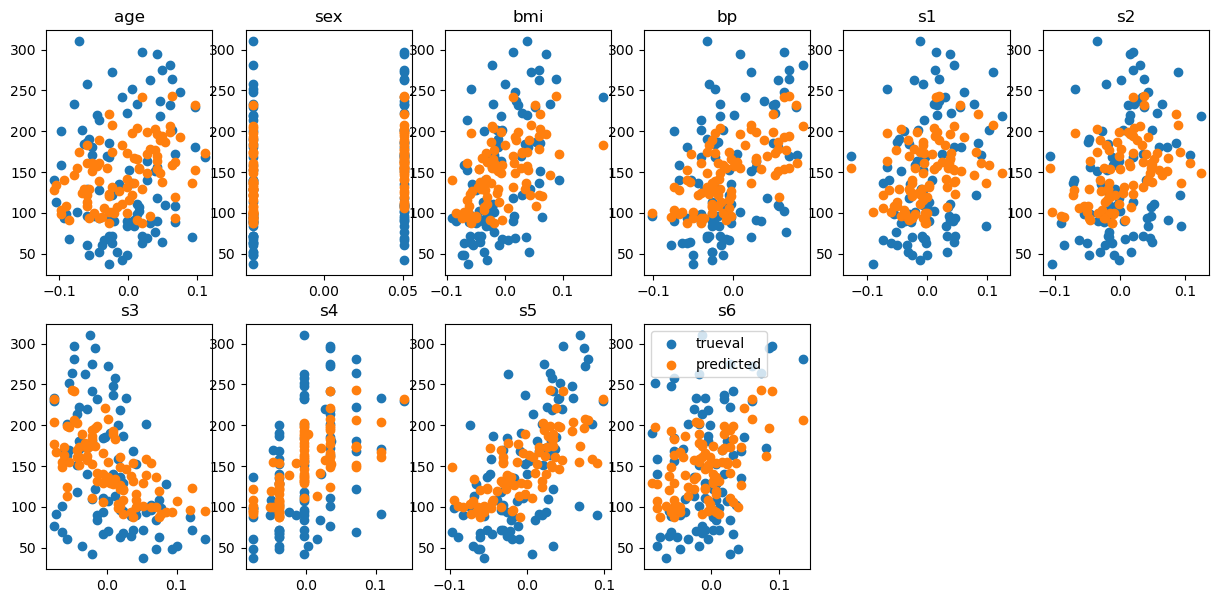

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)
RMSE: 53.730909


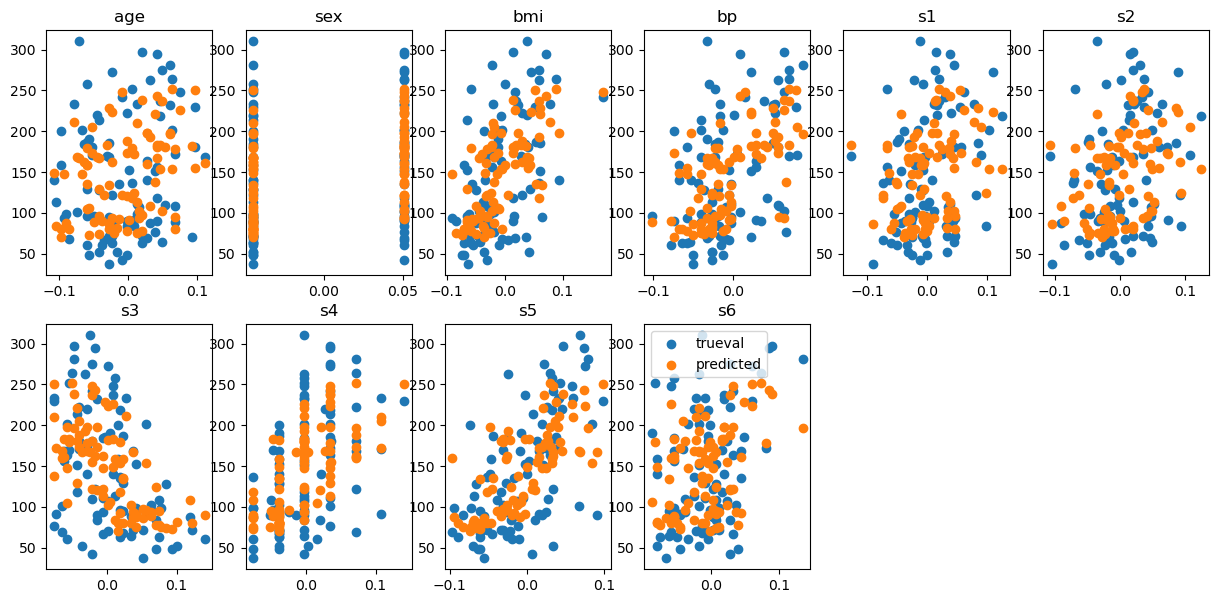

XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)
RMSE: 0.762508


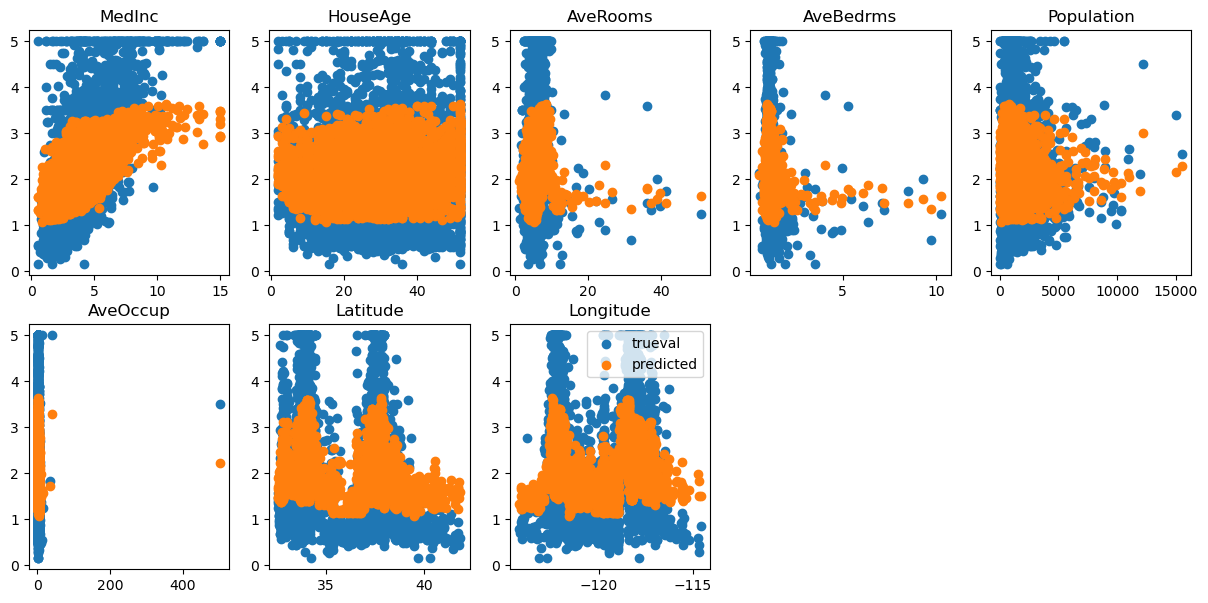

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)
RMSE: 0.631605


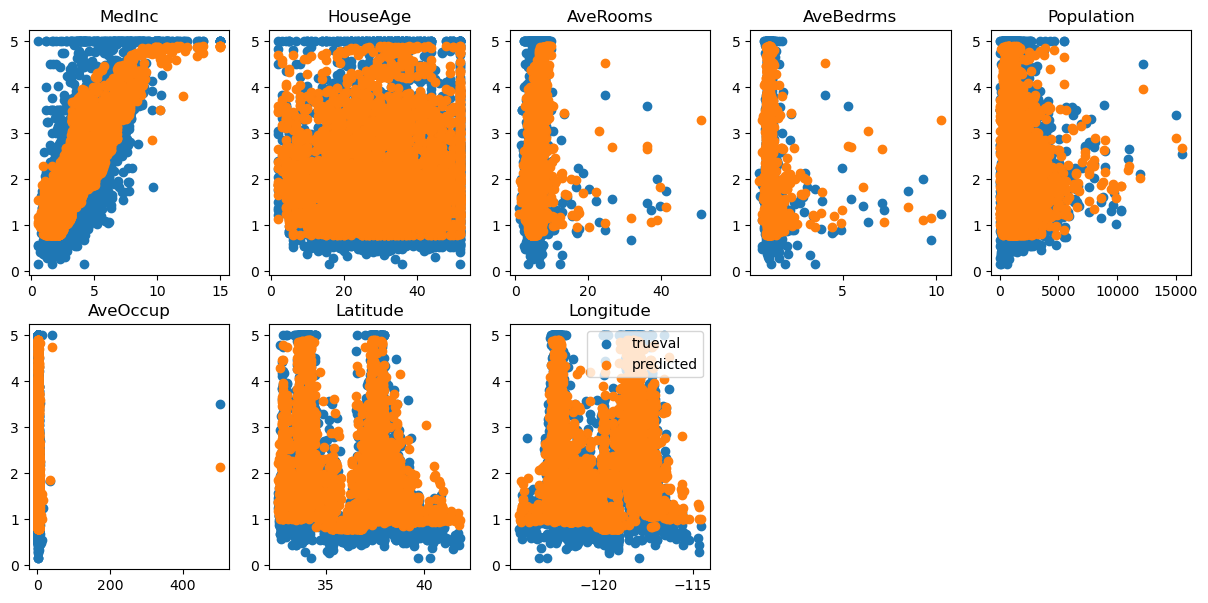

In [13]:
argumentos = dict(objective ='reg:squarederror',
                         colsample_bytree = 0.3,
                         learning_rate = 0.2,
                         max_depth = 10, 
                         alpha = 50, 
                         n_estimators = 10) #jugar con esto

xg_regb = [XGBRegressor(**argumentos), 
        XGBRFRegressor()]

xg_regc = [XGBRegressor(**argumentos),
        XGBRFRegressor()]

diabetes_set = (xg_regb, Xb_train, yb_train, Xb_test, yb_test)
california_set = (xg_regc, Xc_train, yc_train, Xc_test, yc_test)

for (dataset_models, X_train, y_train, X_test, y_test) in (diabetes_set, california_set):
    for model in dataset_models:
        print(model)
        model.fit(X_train,y_train)
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        print("RMSE: %f" % (rmse))

        plt.figure(figsize=(15,7))
        for i, var in enumerate(X_test):
            plt.subplot(2, int(X_test.shape[1]/2) + 1, i+1)
            plt.scatter(X_test.loc[:,var],y_test, label='trueval')
            plt.scatter(X_test.loc[:,var],preds, label='predicted')
            plt.title(var)
        plt.legend()
        plt.show()


In [14]:
xg_regb[0]

XGBRegressor(alpha=50, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

### Podemos plotear el árbol

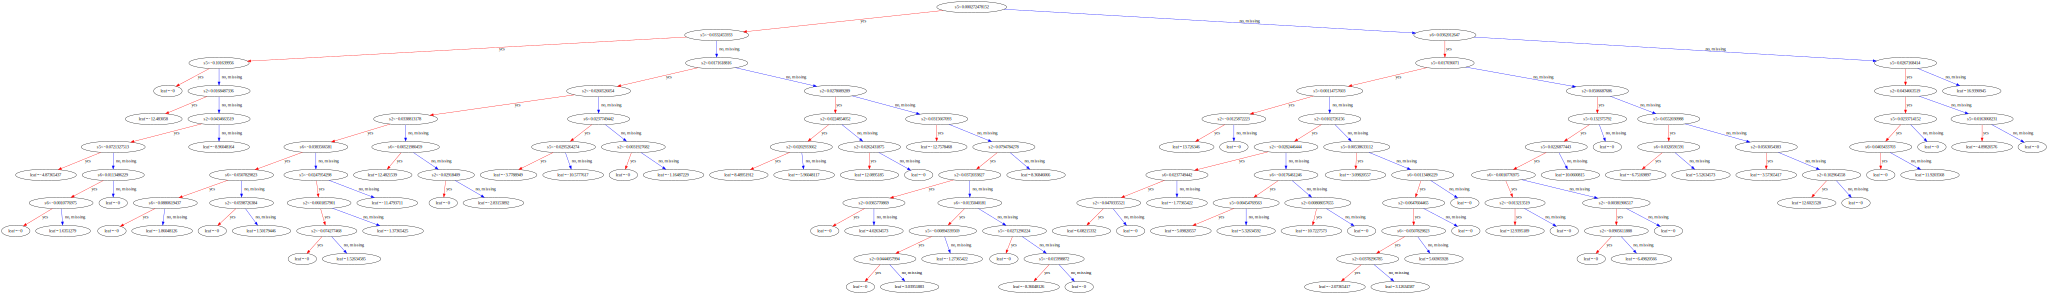

In [15]:
from xgboost import to_graphviz
to_graphviz(xg_regb[0])

# Y para problemas de clasificación?

In [16]:
from sklearn.model_selection import KFold

In [17]:
iris = load_wine()

X = iris["data"]
y = iris["target"]

FOLDS=4
cv = KFold(n_splits=FOLDS, shuffle=True, random_state=4)

El parámetro `objective` es la función objetivo a minimizar. Para problemas de clasificación multiclase usualmente usamos `multi:softmax` debido a que da una "probabilidad" para cada clase. 

Tiene la forma:

$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K{e^{z_j}}}$ para $i=1, \dots, K$ y $\mathbf{z} = (z_1, \dots, z_K) \in \mathbb{R}^K $

Se puede ver la [documentacion](https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters) para otras funciones objetivo.

In [18]:
clfs = [XGBClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10),
        XGBRFClassifier(objective = "multi:softmax", colsample_bytree = 0.3, learning_rate = 0.1,
                           max_depth = 5, alpha = 10, n_estimators = 10),
        RandomForestClassifier()]

clfs_names = ['XGBC', 'XGBRFC', 'RF']


XGBC
Acc. fold 1: 97.78
Acc. fold 2: 100.00
Acc. fold 3: 97.73
Acc. fold 4: 97.73
Avg. accuracy = 98.30808080808082
XGBRFC
Acc. fold 1: 97.78
Acc. fold 2: 93.33
Acc. fold 3: 97.73
Acc. fold 4: 97.73
Avg. accuracy = 96.64141414141415
RF
Acc. fold 1: 97.78
Acc. fold 2: 97.78
Acc. fold 3: 95.45
Acc. fold 4: 97.73
Avg. accuracy = 97.18434343434343


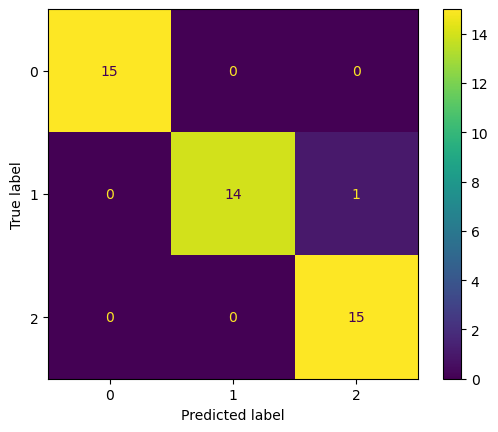

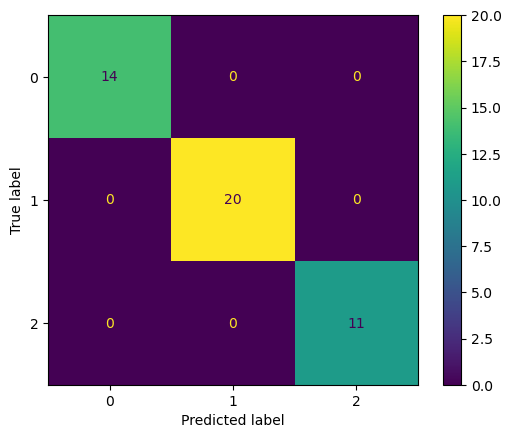

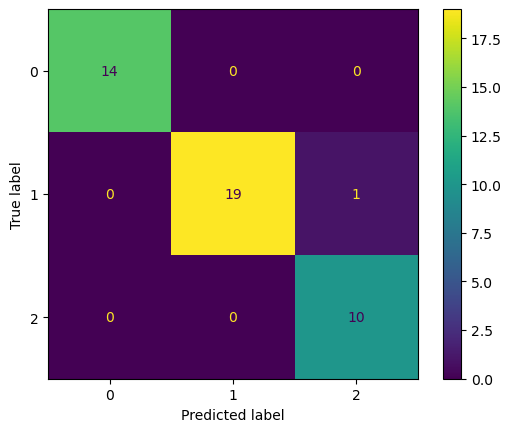

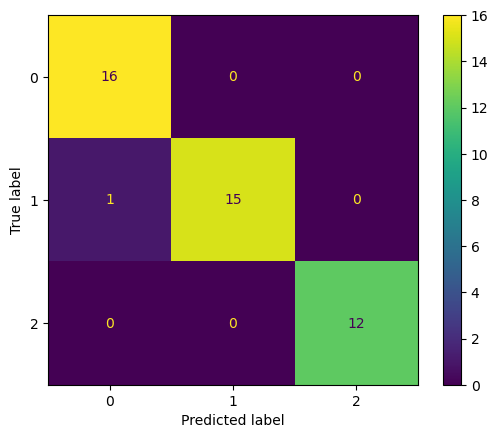

In [19]:
for clf, name in zip(clfs, clfs_names):
    avg_accuracy = 0
    print(name)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X,y)):
        X_train, y_train = X[train_idx], y[train_idx]
        X_test, y_test = X[val_idx], y[val_idx]
        clf.fit(X_train,y_train)
        preds = clf.predict(X_test)
        accuracy = accuracy_score(y_test, preds)
        avg_accuracy +=accuracy
        print(f"Acc. fold {fold+1}: {accuracy * 100.0 :.2f}" % ())
        if name == 'XGBC':
            ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)
    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

## Referencias:

  * [Wikipedia sobre XGBoost](https://es.wikipedia.org/wiki/XGBoost)
  * [Documentación de XGBoost](https://xgboost.readthedocs.io/en/stable/)
  * [Gradient Boosting in SciKit Learn](https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting)